1. import를 하여 필요한 라이브러리나 모듈을 호출합니다.

In [19]:
import random
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from matplotlib import font_manager
from sklearn.preprocessing import MinMaxScaler

2. 고정된 seed값을 지정합니다.

In [20]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
seed_everything(42)

3. 한글깨짐을 방지하기 위해 matplotlib의 한글패치를 진행하였습니다.

In [21]:
font_path = "C:/Windows/Fonts/malgun.ttf"
font_prop = font_manager.FontProperties(fname=font_path)
plt.rcParams["font.family"] = font_prop.get_name()

4. pandas를 이용하여 train과 test 데이터를 불러옵니다.

In [22]:
train_data = pd.read_csv("train.csv")
test_data = pd.read_csv("test.csv")

# 데이터 프레임 정보 추출
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36581 entries, 0 to 36580
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   ID              36581 non-null  object 
 1   월               36581 non-null  int64  
 2   일               36581 non-null  int64  
 3   측정 시간대          36581 non-null  object 
 4   섭씨 온도(°⁣C)      36581 non-null  float64
 5   절대 온도(K)        36581 non-null  float64
 6   이슬점 온도(°C)      36581 non-null  float64
 7   상대 습도 (%)       36581 non-null  float64
 8   대기압(mbar)       36581 non-null  float64
 9   포화 증기압(mbar)    36581 non-null  float64
 10  실제 증기압(mbar)    36581 non-null  float64
 11  증기압 부족량(mbar)   36581 non-null  float64
 12  수증기 함량 (g/kg)   36581 non-null  float64
 13  공기 밀도 (g/m**3)  36581 non-null  float64
 14  풍향 (deg)        36581 non-null  float64
 15  풍속 (m/s)        36581 non-null  float64
dtypes: float64(12), int64(2), object(2)
memory usage: 4.5+ MB


5. info 함수를 통해 다음과 같은 정보를 얻을 수 있습니다.
    + 이 데이터셋은 결측치가 없다는 것을 확인하였습니다.
    + 풍향을 예측한다는 점과 데이터를 분석한 결과 시계열 분포인 것을 확인하였습니다.
    + 그리고 측정 시간대가 문자열로 이루어져 있기 때문에 categorical을 이용해야 한다고 판단하였습니다.

6. train 데이터의 특성과 타겟을 나누고 측정 시간대 데이터의 분포를 확인합니다.

In [23]:
features = train_data.drop(['ID', '풍속 (m/s)'], axis=1)
target = train_data['풍속 (m/s)']

 
# (저녁, 오전, 오후, 새벽)로 확인
time_labels = train_data['측정 시간대'].unique()

7. 측정 시간대가 수치로 구성되어 있지 않기 때문에 one-hot-encoding을 진행합니다.

In [24]:
# 측정 시간대 특성을 integer로 변환
time_label_mapping = {label: idx for idx, label in enumerate(time_labels)}
features['측정 시간대'] = features['측정 시간대'].map(time_label_mapping)


## tf.keras.utils.to_categorical 함수를 사용해서 one-hot encoding 진행
categorical_feature = features['측정 시간대']
categorical_feature = tf.keras.utils.to_categorical(categorical_feature)

8. 데이터 전처리는 MinMaxScaler를 사용하였습니다.

In [25]:
scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(features)
x_train = np.reshape(scaled_features, (scaled_features.shape[0], 1, scaled_features.shape[1]))

9. LSTM과 GRU 모델을 합쳐서 제작해보았습니다.
    마지막에 Dense(1)은 Regression을 나타내기 위해 추가하였습니다.

In [26]:
import tensorflow as tf

# LSTM 모델 정의
lstm_model = tf.keras.Sequential([
    tf.keras.layers.LSTM(32, input_shape=(x_train.shape[1], x_train.shape[2]), return_sequences=True),
    tf.keras.layers.LSTM(32, return_sequences=True),
    tf.keras.layers.LSTM(64),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(1)
])

# GRU 모델 정의
gru_model = tf.keras.Sequential([
    tf.keras.layers.GRU(32, input_shape=(x_train.shape[1], x_train.shape[2]), return_sequences=True),
    tf.keras.layers.GRU(32, return_sequences=True),
    tf.keras.layers.GRU(64),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(1)
])

# 모델 합치기
input_layer = tf.keras.layers.Input(shape=(x_train.shape[1], x_train.shape[2]))
lstm_output = lstm_model(input_layer)
gru_output = gru_model(input_layer)

# LSTM과 GRU 모델의 출력을 Concatenate 레이어를 통해 결합
combined_output = tf.keras.layers.Concatenate()([lstm_output, gru_output])
# 이후 추가적인 레이어를 적용하여 풍속 예측을 위한 최종 레이어 구성 가능
output_layer = tf.keras.layers.Dense(1)(combined_output)

# 새로운 모델 생성
combined_model = tf.keras.models.Model(inputs=input_layer, outputs=output_layer)

combined_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 1, 14)]              0         []                            
                                                                                                  
 sequential_2 (Sequential)   (None, 1)                    80769     ['input_2[0][0]']             
                                                                                                  
 sequential_3 (Sequential)   (None, 1)                    71361     ['input_2[0][0]']             
                                                                                                  
 concatenate_1 (Concatenate  (None, 2)                    0         ['sequential_2[0][0]',        
 )                                                                   'sequential_3[0][0]']  

10. 모델 컴파일을 진행하였습니다. loss는 대회에서 지정해준 MAE를 사용하였습니다.

In [27]:
# 모델 컴파일
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
combined_model.compile(optimizer=opt, loss='MAE', metrics=['MAE'])

11. 모델 학습을 진행합니다.

In [ ]:
# 모델 훈련
model_train = combined_model.fit(x_train, target, epochs=10000, batch_size=32,
                                 validation_split=0.2, verbose=1)

12. matplotlib를 이용하여 시각화하였습니다.

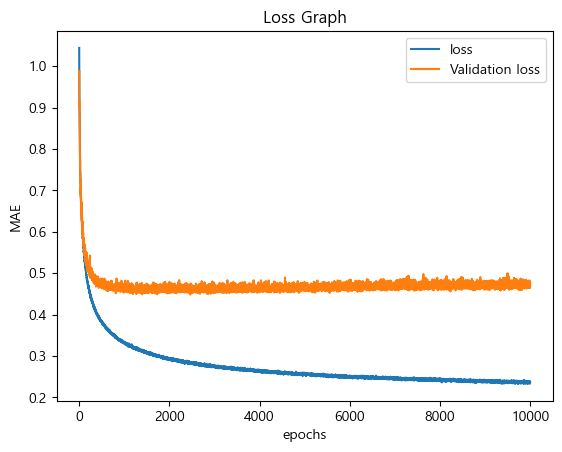

In [29]:
plt.plot(model_train.history['loss'], label='loss')
plt.plot(model_train.history['val_loss'], label='Validation loss')
plt.title('Loss Graph')
plt.xlabel('epochs')
plt.ylabel('MAE')
plt.legend()
plt.show() 

13. test 데이터에도 수행합니다.

In [30]:
test_features = test_data.drop(['ID'], axis=1)
test_time_labels = test_data['측정 시간대'].unique()
test_time_label_mapping = {label: idx for idx, label in enumerate(test_time_labels)}
test_features['측정 시간대'] = test_features['측정 시간대'].map(test_time_label_mapping)

14. 테스트 데이터에 대해 훈련 데이터에서 사용한 scaler를 그대로 사용합니다.

In [31]:
test_scaled_features = scaler.transform(test_features)
x_test = np.reshape(test_scaled_features, (test_scaled_features.shape[0], 1, test_scaled_features.shape[1]))


15. test 데이터로 모델을 예측합니다.

In [32]:
predictions = combined_model.predict(x_test)

490/490 [==============================] - 2s 1ms/step


16. 예측 결과를 시각화하였습니다.

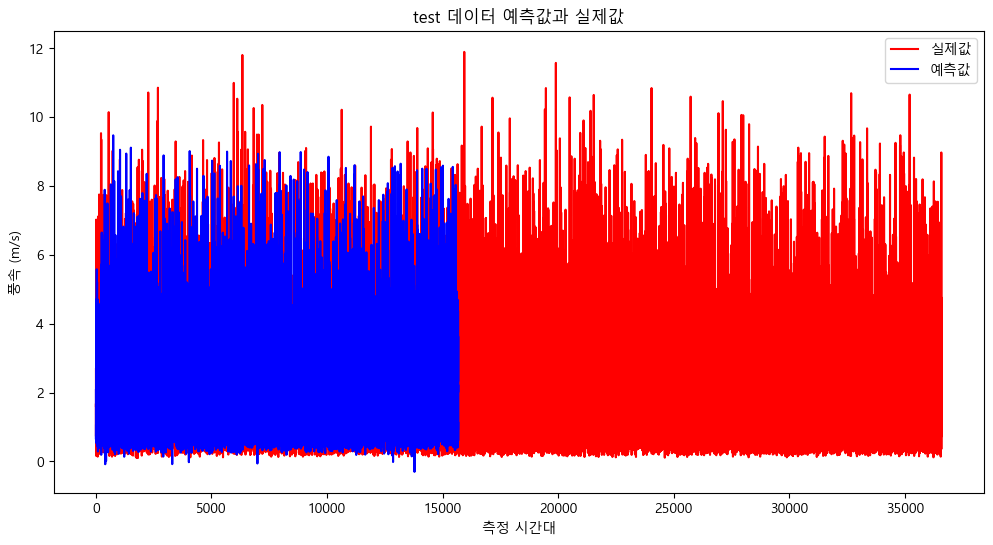

In [33]:
plt.figure(figsize=(12, 6))
plt.plot(target.values, label='실제값', color='red')
plt.plot(predictions, label='예측값', color='blue')
x_ticks = test_data['측정 시간대'].index
plt.title("test 데이터 예측값과 실제값")
plt.xlabel('측정 시간대')
plt.ylabel('풍속 (m/s)')
plt.legend()
plt.show()

17. submission DataFrame을 CSV 파일로 저장합니다.

In [34]:
submission = pd.DataFrame()
submission['ID'] = test_data['ID']
submission['풍속 (m/s)'] = predictions
submission.to_csv('submission.csv', index=False)